In [59]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from pandas import DataFrame
from typing import List

%matplotlib inline

## Анализ данных

#### Работа с пропусками

Загрузим датасет и проверим его на пропуски в данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Два признака в которых есть пропуски - это Item_Weight и Outlet_Sze, вес товара и размер магазина соответственно.

Пропуски нужно как-то заполнить. Есть предположение, что вес товаров в одной категории должен быть примерно одинаковым. Проверим это предположение.

In [5]:
# всего 16 категорий
df.Item_Type.unique().shape

(16,)

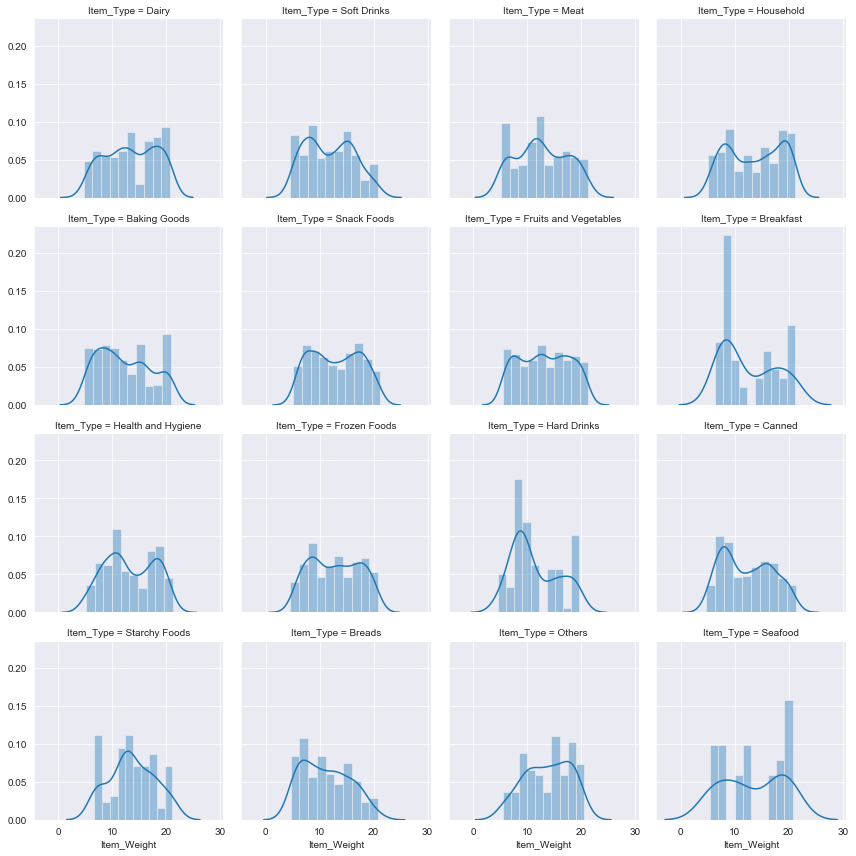

In [6]:
# визуализируем распределние веса товаров с помощью гистограммы
sns.set_style('darkgrid')
df_plot = df.dropna()

g = sns.FacetGrid(df_plot, col='Item_Type', col_wrap=4)
g.map(sns.distplot, 'Item_Weight', bins=10)
plt.show()

На графиках не получилось заметить нормальное распределение веса, для большинства категорий распределние веса товаров скорее равномерное.

В датасете указанны данные о продажах. Один и тот же товар может быть в разных магазинах, проверим сколько в датасете уникальных товаров.

In [7]:
# всего 1559 уникальных товаров
df.Item_Identifier.unique().shape

(1559,)

Если данных о весе товара нет у одного магазина, то это не значит, что их нет у другого магазина. Скорее всего можно будет восстановить данные о весе по данным другого магазина об этом товаре.

In [8]:
df[df['Item_Weight'].isnull()].head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.12747,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636


In [9]:
df[df.Item_Identifier == 'FDP10'].head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
585,FDP10,19.0,Low Fat,0.128066,Snack Foods,104.3622,OUT035,2004,Small,Tier 2,Supermarket Type1,1905.5196
2623,FDP10,19.0,Low Fat,0.128815,Snack Foods,107.6622,OUT017,2007,NaN,Tier 2,Supermarket Type1,1164.4842


Предположение подтвердилось, данные о весе можно восстановить по данным из других магазинов. 

Теперь напишем функцию, для заполнения пропущенных полей.

In [10]:
def fill_weight(df: DataFrame, category: str) -> List[float]:
    new_weights = []
    for i in df.index:
        if math.isnan(df.loc[i, category]):
            id = df.loc[i, 'Item_Identifier']
            condition = (df['Item_Identifier'] == id) & df[category].notnull()
            try:
                weight = df[condition][category].iloc[0]
            except IndexError:
                weight = df.loc[i, category]
        else:
            weight = df.loc[i, category]
    
        new_weights.append(weight)
    
    return new_weights

In [11]:
new_weights = fill_weight(df, 'Item_Weight')

df['Item_Weight'] = new_weights

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Мы успешно заполнили практически все пропуски.

In [13]:
df[df['Item_Weight'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [14]:
df[df.Item_Identifier == 'FDN52'].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564


Каждый из оставшихся товаров есть только в одном магазине, поэтому пропуски заполнить не удалось. Можно заолнить пропуск средним значением для категории, но лучше этого не делать, так как это может повлиять на качество модели. Лучше удалить эти 4 строчки из выборки, но перед тем, как это делать, нужно обработать пропуски для колонки Outlet Size.

Для начала, проверим, можно ли восстановить размер магазина по информации из других строк.

In [15]:
df[df['Outlet_Size'].isnull()].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344


In [16]:
cond = (df.Outlet_Identifier == 'OUT010') & df.Outlet_Size.notnull() 
df[cond].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


Информация о размере магазина отсутсвует для всех идентификаторов этого магазина. Каждый магазин расположен в определенно категории города и у каждого магазина есть свой тип. Попробуем сгруппировать размер магазина по этим признакам. 

In [17]:
print('Все уникальные Outlet_Location_Type:', df.Outlet_Location_Type.unique())

Все уникальные Outlet_Location_Type: ['Tier 1' 'Tier 3' 'Tier 2']


In [18]:
print('Все уникальные Outlet_Type:', df.Outlet_Type.unique())

Все уникальные Outlet_Type: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [19]:
df.groupby(['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']).count()

Item_Identifier  \
Outlet_Location_Type Outlet_Type       Outlet_Size                    
Tier 1               Grocery Store     Small                    528   
                     Supermarket Type1 Medium                   930   
                                       Small                    930   
Tier 2               Supermarket Type1 Small                    930   
Tier 3               Supermarket Type1 High                     932   
                     Supermarket Type2 Medium                   928   
                     Supermarket Type3 Medium                   935   

                                                    Item_Weight  \
Outlet_Location_Type Outlet_Type       Outlet_Size                
Tier 1               Grocery Store     Small                527   
                     Supermarket Type1 Medium               930   
                                       Small                930   
Tier 2               Supermarket Type1 Small                930   
Tier 3               Supermarket Type1 High                 932   
                     Supermarket Type2 Medium               928   
                     Supermarket Type3 Medium               932   

                                                    Item_Fat_Content  \
Outlet_Location_Type Outlet_Type       Outlet_Size                     
Tier 1               Grocery Store     Small                     528   
                     Supermarket Type1 Medium                    930   
                                       Small                     930   
Tier 2               Supermarket Type1 Small                     930   
Tier 3               Supermarket Type1 High                      932   
                     Supermarket Type2 Medium                    928   
                     Supermarket Type3 Medium                    935   

                                                    Item_Visibility  \
Outlet_Location_Type Outlet_Type       Outlet_Size                    
Tier 1               Grocery Store     Small                    528   
                     Supermarket Type1 Medium                   930   
                                       Small                    930   
Tier 2               Supermarket Type1 Small                    930   
Tier 3               Supermarket Type1 High                     932   
                     Supermarket Type2 Medium                   928   
                     Supermarket Type3 Medium                   935   

                                                    Item_Type  Item_MRP  \
Outlet_Location_Type Outlet_Type       Outlet_Size                        
Tier 1               Grocery Store     Small              528       528   
                     Supermarket Type1 Medium             930       930   
                                       Small              930       930   
Tier 2               Supermarket Type1 Small              930       930   
Tier 3               Supermarket Type1 High               932       932   
                     Supermarket Type2 Medium             928       928   
                     Supermarket Type3 Medium             935       935   

                                                    Outlet_Identifier  \
Outlet_Location_Type Outlet_Type       Outlet_Size                      
Tier 1               Grocery Store     Small                      528   
                     Supermarket Type1 Medium                     930   
                                       Small                      930   
Tier 2               Supermarket Type1 Small                      930   
Tier 3               Supermarket Type1 High                       932   
                     Supermarket Type2 Medium                     928   
                     Supermarket Type3 Medium                     935   

                                                    Outlet_Establishment_Year  \
Outlet_Location_Type Outlet_Type       Outlet_Size                              
Tier 1               Gr

Из этой группировки, можно сделать выводы о том, каким скорее всего должен быть размер магазина в зависимости от категории города и типа магазина.

Для каждого города и типа магазина, есть свой размер. Исключением является город Tier 1 и магазин Supermarket Type 1, это комбинция может означать, как средний, так и большой магазин. Чтобы понять, насколько это критично для заполнения пропусков, посмотрим для скольки магазинов с такой комбинацией город/тип магазина отсутсвует размер.

In [20]:
cond = (df.Outlet_Location_Type == 'Tier 1') & (df.Outlet_Type == 'Supermarket Type1') & df.Outlet_Size.isnull()
df[cond]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


Нам повезло и в датасете нет магазинов с отсутствующим размером для данной комбинации город/тип магазина.

Теперь напишем функцию, которая заполнит пропуски в Outlet_Size.

In [21]:
def fill_size(df: DataFrame) -> List[str]:
    new_sizes = []
    for i in df.index:
        if df.loc[i, 'Outlet_Location_Type'] == 'Tier 1' and df.loc[i, 'Outlet_Type'] == 'Grocery Store':
            size = 'Small'
        elif df.loc[i, 'Outlet_Location_Type'] == 'Tier 2' and df.loc[i, 'Outlet_Type'] == 'Supermarket Type1':
            size = 'Small'
        elif df.loc[i, 'Outlet_Location_Type'] == 'Tier 3':
            if df.loc[i, 'Outlet_Type'] == 'Supermarket Type1':
                size = 'High'
            elif df.loc[i, 'Outlet_Type'] == 'Supermarket Type2':
                size = 'Medium'
            elif df.loc[i, 'Outlet_Type'] == 'Supermarket Type3':
                size = 'Medium'
        else:
            size = df.loc[i, 'Outlet_Size']
    
        new_sizes.append(size)
    
    return new_sizes

In [22]:
new_sizes = fill_size(df)

df['Outlet_Size'] = new_sizes

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  8523 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Все данные Outlet_Size заполнены, теперь осталось только удалить 4 строки, в которых отсутствуют данные о весе.

In [24]:
df.dropna(inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8519 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8519 non-null object
Item_Visibility              8519 non-null float64
Item_Type                    8519 non-null object
Item_MRP                     8519 non-null float64
Outlet_Identifier            8519 non-null object
Outlet_Establishment_Year    8519 non-null int64
Outlet_Size                  8519 non-null object
Outlet_Location_Type         8519 non-null object
Outlet_Type                  8519 non-null object
Item_Outlet_Sales            8519 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


#### Обработка категориальных признаков

In [30]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Для начала уберем Item_Identifier и Outlet_Identifier. Эти данные не несут никакой полезной нагрузки.

In [31]:
data = df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

In [32]:
data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,Medium,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


Теперь проверим, как много значений в категориальных признаках.

In [35]:
print('Item_Fat_Content:', data.Item_Fat_Content.unique().shape[0])
print('Item_Type:', data.Item_Type.unique().shape[0])
print('Outlet_Size:', data.Outlet_Size.unique().shape[0])
print('Outlet_Location_Type:', data.Outlet_Location_Type.unique().shape[0])
print('Outlet_Type:', data.Outlet_Type.unique().shape[0])
print('Outlet_Establishment_Year:', data.Outlet_Establishment_Year.unique().shape[0])

Item_Fat_Content: 5
Item_Type: 16
Outlet_Size: 3
Outlet_Location_Type: 3
Outlet_Type: 4
Outlet_Establishment_Year: 9


Так же посмотрим сами эти значения

In [53]:
print('Item_Fat_Content:', data.Item_Fat_Content.unique(), '\n')
print('Item_Type:', data.Item_Type.unique(), '\n')
print('Outlet_Size:', data.Outlet_Size.unique(), '\n')
print('Outlet_Location_Type:', data.Outlet_Location_Type.unique(), '\n')
print('Outlet_Type:', data.Outlet_Type.unique(), '\n')
print('Outlet_Establishment_Year:', data.Outlet_Establishment_Year.unique(), '\n')

Item_Fat_Content: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg'] 

Item_Type: ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 

Outlet_Size: ['Medium' 'High' 'Small'] 

Outlet_Location_Type: ['Tier 1' 'Tier 3' 'Tier 2'] 

Outlet_Type: ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3'] 

Outlet_Establishment_Year: [1999 2009 1998 1987 1985 2002 2007 1997 2004] 



Можно увидеть, что в признаке Item_Fat_Content всего 5 значений, но уникальных значений только 2: Low Fat и Regular. Заменим значения в этой категории.

In [54]:
def change_fat_content(df):
    new_fat = []
    for i in df.index:
        if df.loc[i, 'Item_Fat_Content'] == 'Regular' or df.loc[i, 'Item_Fat_Content'] == 'reg':
            fat = 'Regular'
        else:
            fat = 'Low Fat'
    
        new_fat.append(fat)
    
    return new_fat

In [55]:
new_fat = change_fat_content(data)
data['Item_Fat_Content'] = new_fat

In [56]:
print('Item_Fat_Content:', data.Item_Fat_Content.unique())

Item_Fat_Content: ['Low Fat' 'Regular']


Всего уникальных категорий 37, что не очень много, поэтому можно преобразовать их все.

Будем кодировать двумя способами: 
- Для регресионных моделей будем использовать get dummies 
- Для деревьев будем использовать label encoding

In [57]:
data_reg = pd.get_dummies(data, columns=['Item_Fat_Content', 'Item_Type', 
                                      'Outlet_Size', 'Outlet_Location_Type', 
                                      'Outlet_Type', 'Outlet_Establishment_Year'])

In [68]:
data_reg.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Type_Supermarket Type3,Outlet_Establishment_Year_1985,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009
0,9.30,0.016047,249.8092,3735.1380,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5.92,0.019278,48.2692,443.4228,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,17.50,0.016760,141.6180,2097.2700,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,19.20,0.000000,182.0950,732.3800,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,8.93,0.000000,53.8614,994.7052,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [65]:
columns_to_encode = ['Item_Fat_Content', 'Item_Type', 
                     'Outlet_Size', 'Outlet_Location_Type', 
                     'Outlet_Type', 'Outlet_Establishment_Year']

In [66]:
data_trs = data

for col in columns_to_encode:
    le = LabelEncoder()
    new_col = le.fit_transform(data_trs[col])
    data_trs[col] = new_col

data_trs.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,0,0.016047,4,249.8092,4,1,0,1,3735.1380
1,5.92,1,0.019278,14,48.2692,8,1,2,2,443.4228
2,17.50,0,0.016760,10,141.6180,4,1,0,1,2097.2700
3,19.20,1,0.000000,6,182.0950,3,1,2,0,732.3800
4,8.93,0,0.000000,9,53.8614,1,0,2,1,994.7052


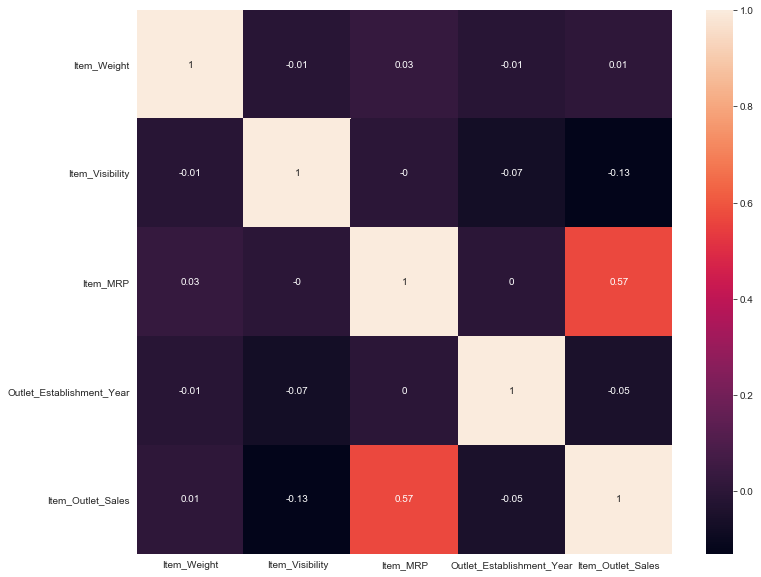

In [36]:
correlation_matrix = data.corr().round(2)
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(data=correlation_matrix, annot=True)

In [39]:
correlation_matrix()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.03,-0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.03,-0.00,1.00,0.00,0.57
Outlet_Establishment_Year,-0.01,-0.07,0.00,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00
